In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import sc_utils

In [2]:
import h5py
import hdf5plugin

In [3]:
pd.options.display.max_rows = 200

In [82]:
%config InlineBackend.figure_format = "retina"

# Explore dataset (via RNA)

## 1. Loading data

I used `h5py` with `hdf5plugin` packages to just read the data. Data is stored as dense matrix with already transformed values. What can we do

In [4]:
f = h5py.File("../data/train_cite_inputs.h5")

In [5]:
expr = f["train_cite_inputs"]["block0_values"][:]

In [6]:
genes = f["train_cite_inputs"]["axis0"].asstr()[:]

In [7]:
cells = f["train_cite_inputs"]["axis1"].asstr()[:]

In [8]:
meta = pd.read_csv("../data/metadata.csv", index_col=0)

In [9]:
obs = meta.loc[cells, :].copy()

I convert gene names to just symbols, but keep the ensembl id part

In [10]:
var = pd.DataFrame(index=genes)

In [11]:
var["ensembl_id"] = var.index.str.split("_").str[0]

In [12]:
var.index = var.index.str.split("_").str[1]

In [13]:
var.index.duplicated().sum()

83

## 2. Basic preprocessing

Construct standard `AnnData` object to explore with familiar methods

In [14]:
ds = anndata.AnnData(expr, obs=obs, var=var)

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
ds.var_names_make_unique()

Here are the provided cell annotation

In [16]:
ds.obs.cell_type.value_counts()

HSC     29879
EryP    14241
NeuP    12493
MasP     8242
MkP      5382
MoP       591
BP        160
Name: cell_type, dtype: int64

In [17]:
ds.var['mito'] = ds.var_names.str.match("MT-")

Compute the regular QC metrics, but the caveat is that they are derived from log-transformed normalized counts

In [18]:
sc.pp.calculate_qc_metrics(ds, qc_vars=['mito'], percent_top=None, log1p=False, inplace=True)

In [19]:
ds.obs["sample"] = ds.obs.donor.astype(str) + "_" + ds.obs.day.astype(str)

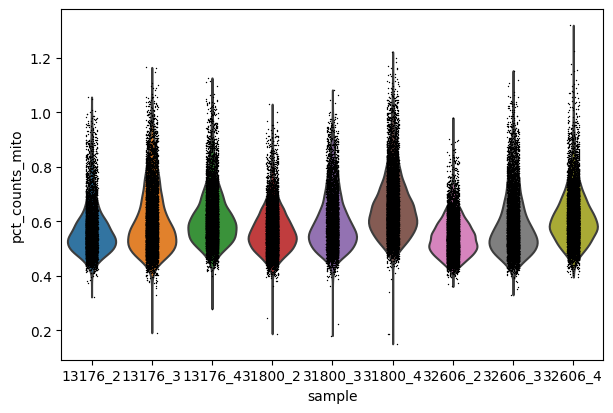

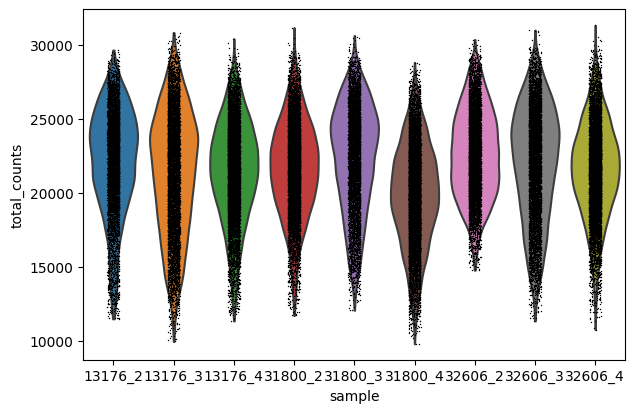

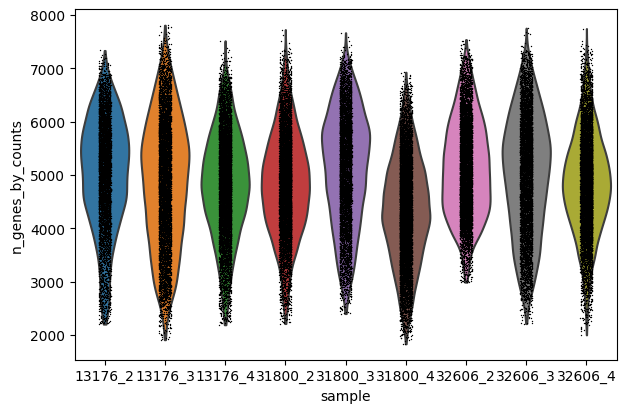

In [20]:
sc.pl.violin(ds, "pct_counts_mito", groupby="sample")
sc.pl.violin(ds, "total_counts", groupby="sample")
sc.pl.violin(ds, "n_genes_by_counts", groupby="sample")

## 3. Cell type composition

In [21]:
cell_types = pd.crosstab(ds.obs.cell_type, ds.obs["sample"])

In [22]:
cell_types = cell_types / cell_types.sum(axis="rows")

Let's plot cell type composition per sample, normalized by row:  
— black is minimum per row (not necessary 0)  
— bright beige is maximum per row

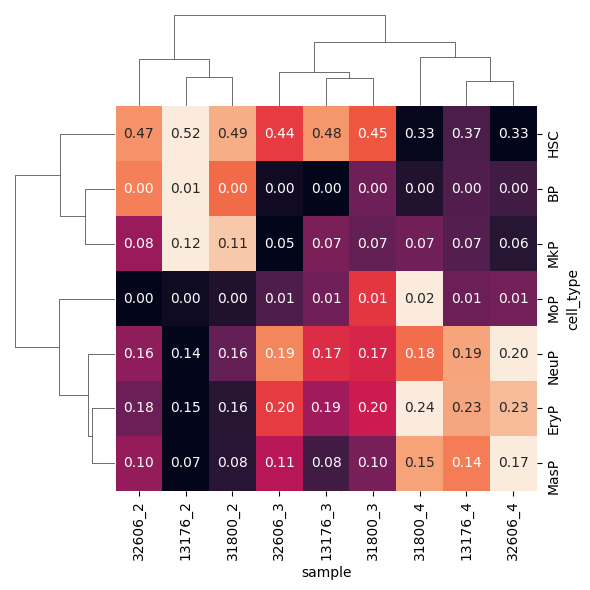

In [23]:
sns.clustermap(
    cell_types,
    standard_scale=0,
    figsize=(6, 6),
    cbar_pos=None,
    fmt=".2f",
    annot=cell_types
)

Here black actually means 0

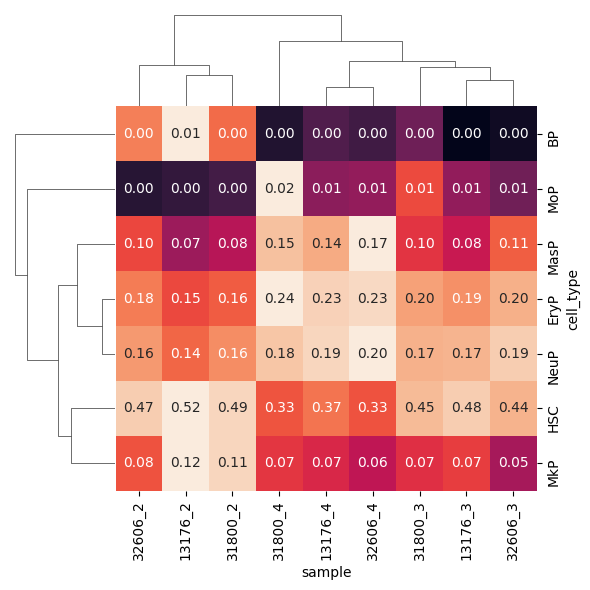

In [24]:
sns.clustermap(
    cell_types.div(cell_types.max(axis="columns"), axis="rows"),
    # standard_scale=0,
    figsize=(6, 6),
    cbar_pos=None,
    fmt=".2f",
    annot=cell_types
)

**Results:**
* samples change over time
* samples change over time in mostly consistent manner
* BP are seen almost exclusively at day 2
* MkP, HSC are higher at day 2 and decline
* NeuP, MasP, EryP and MoP rise
* 1 donor has more MoP at day 4 than rest (also at day 3)

Check donor sex

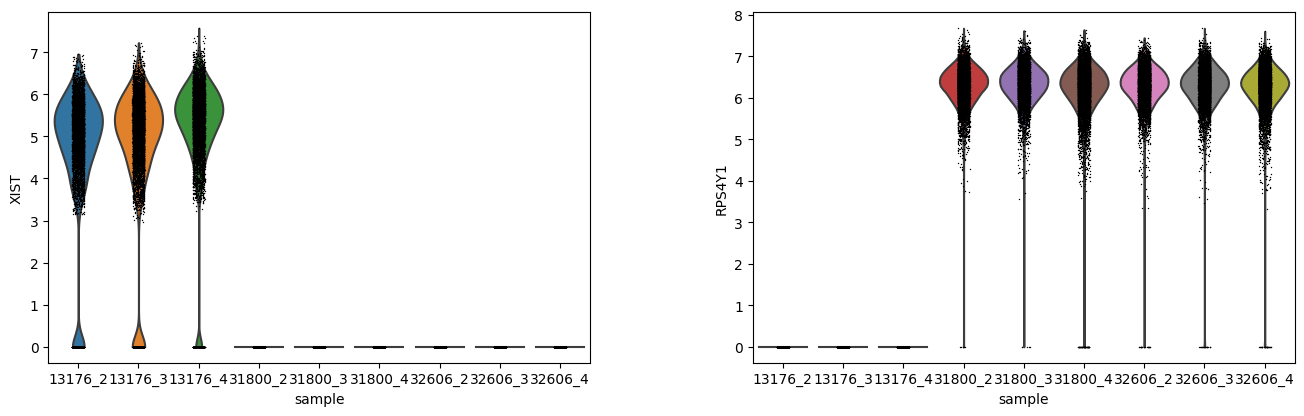

In [25]:
sc.pl.violin(ds, ["XIST", "RPS4Y1"], groupby="sample")

**Results**:
* 1 female donor (13176)
* 2 male (31800, 32606)

## 4. Standard clustering analysis

In [26]:
sc.pp.highly_variable_genes(
    ds, 
    flavor="seurat",
    n_top_genes=2000
)

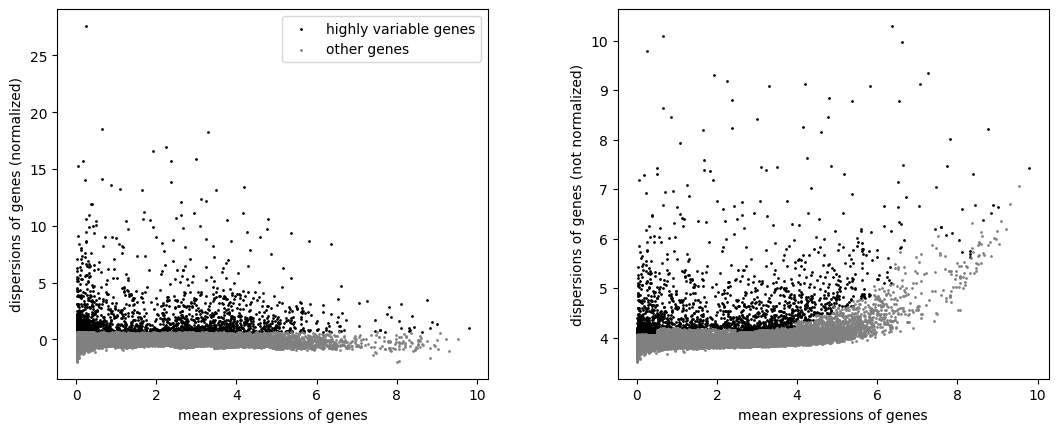

In [27]:
sc.pl.highly_variable_genes(ds)

In [28]:
ds.raw = ds

In [29]:
ds = ds[:, ds.var.highly_variable]

In [30]:
sc.pp.scale(ds, max_value=10)

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [31]:
sc.tl.pca(ds, svd_solver='arpack')

In [32]:
ds.obs.donor = ds.obs.donor.astype(str)
ds.obs.day = ds.obs.day.astype(str)

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


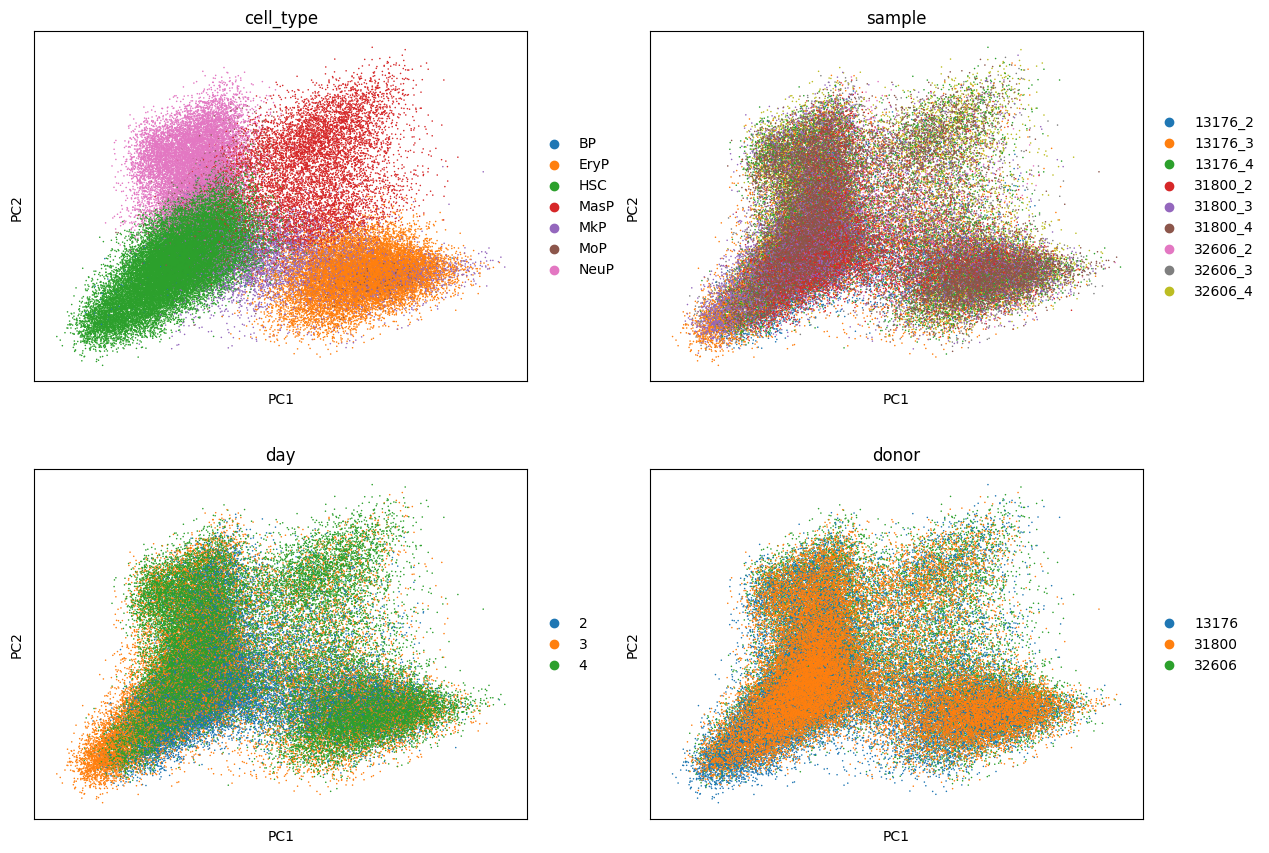

In [33]:
sc.pl.pca(ds, color=['cell_type', "sample", "day", "donor"], size=5, ncols=2)

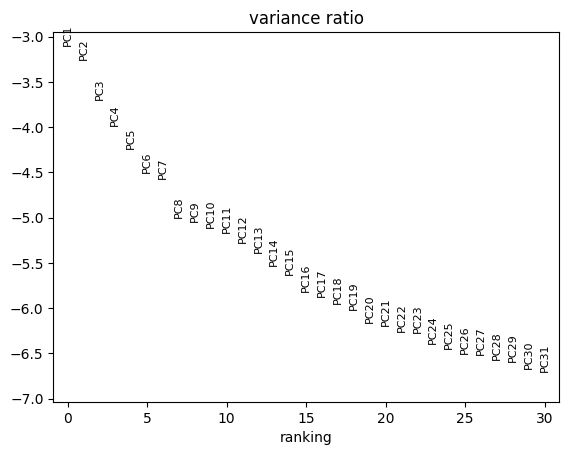

In [34]:
sc.pl.pca_variance_ratio(ds, log=True)

In [35]:
sc.pp.neighbors(ds, n_neighbors=10, n_pcs=7)

In [36]:
sc.tl.leiden(ds, resolution=0.5)

In [37]:
sc.tl.paga(ds)

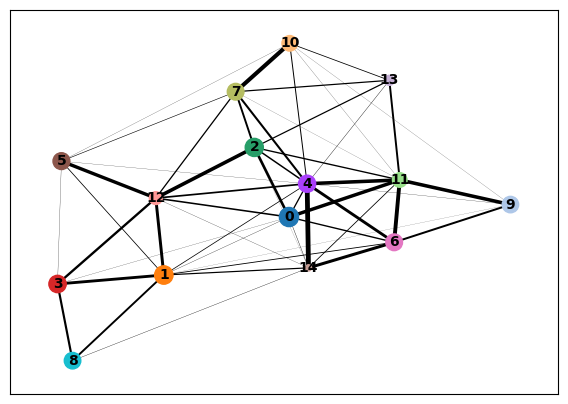

In [38]:
sc.pl.paga(ds)

In [39]:
sc.tl.umap(ds, init_pos='paga')

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


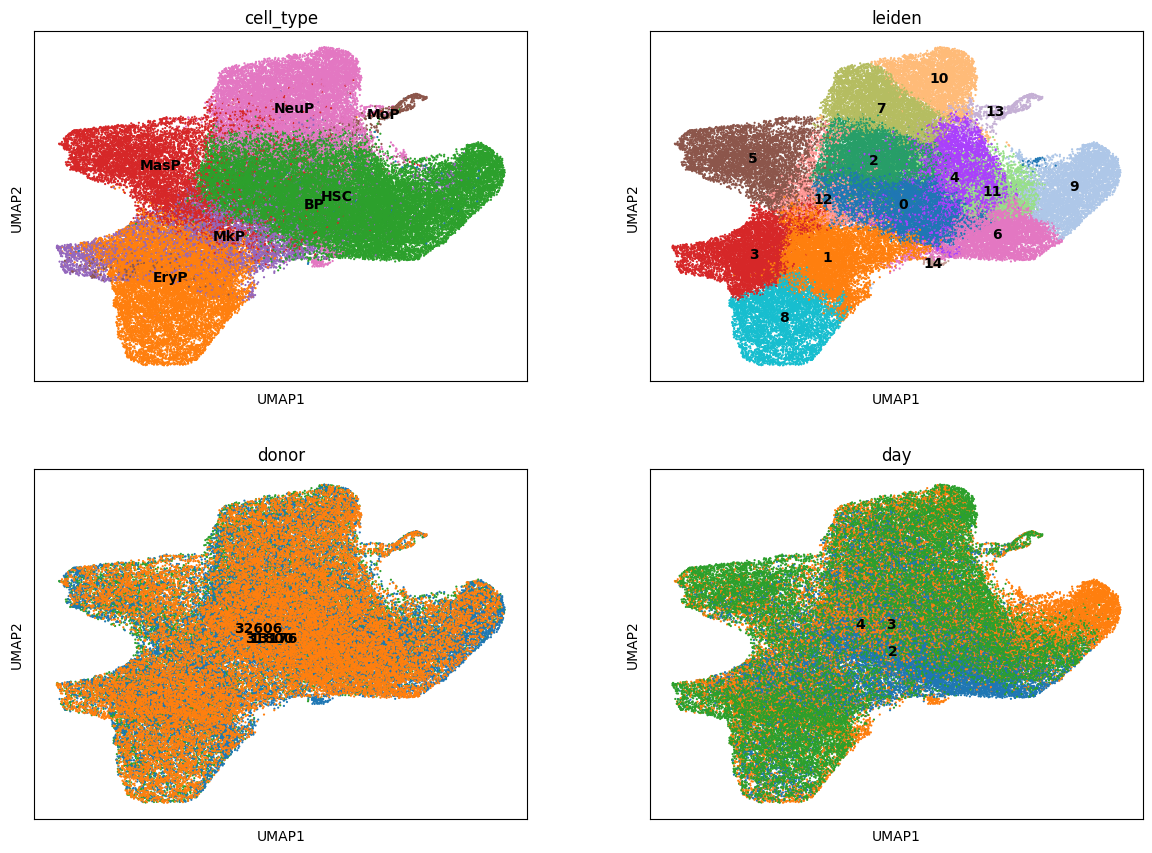

In [40]:
sc.pl.umap(ds, color=["cell_type", "leiden", "donor", "day"], size=10, legend_loc="on data", ncols=2)

**Results**:
* integration looks pretty good, no need for batch effect correction, additional integration
* for MoP, MasP leiden clusters agree with the provided labels
* for other cell types there are disagreements
* **NB** this is only one HVG/PC/Resolution snapshot

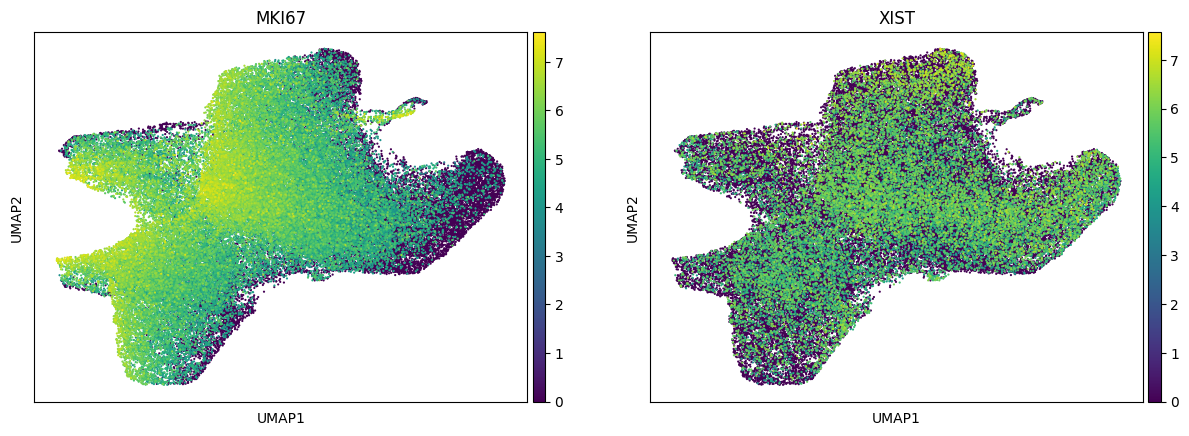

In [41]:
sc.pl.umap(ds, color=["MKI67", "XIST"], size=10)

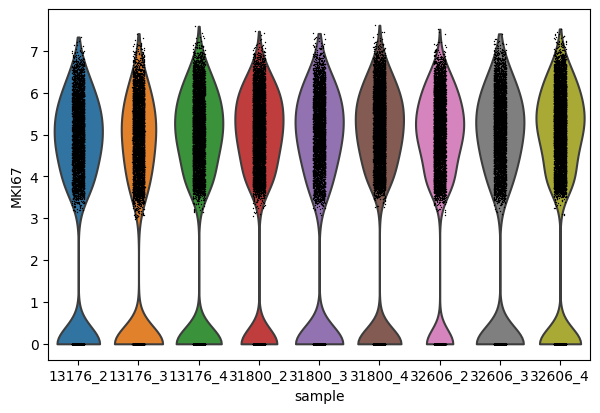

In [42]:
sc.pl.violin(ds, "MKI67", groupby="sample")

**Results**:
* There seems to be no batch effect between samples based on MKI67 expression

In [43]:
sc.tl.rank_genes_groups(ds, 'leiden', method='t-test', n_genes=50)

In [45]:
markers = sc_utils.get_markers(ds, "leiden")

In [46]:
markers.cluster = markers.cluster.astype(int)
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)

In [47]:
markers.groupby("cluster").head(5)

p_val  avg_logFC     pct.1     pct.2      p_val_adj  cluster  \
1     0.000000e+00   4.844846  0.966096  0.464173   0.000000e+00        0   
11    0.000000e+00   3.634046  0.847821  0.381840   0.000000e+00        0   
5     0.000000e+00   3.562626  0.900511  0.427781   0.000000e+00        0   
0     0.000000e+00   3.533764  0.995442  0.645874   0.000000e+00        0   
13    0.000000e+00   3.233646  0.840485  0.391373   0.000000e+00        0   
50    0.000000e+00   5.443936  0.939715  0.306958   0.000000e+00        1   
55    0.000000e+00   4.231024  0.773244  0.249317   0.000000e+00        1   
52    0.000000e+00   4.129589  0.801229  0.268515   0.000000e+00        1   
61    0.000000e+00   3.939960  0.766183  0.278003   0.000000e+00        1   
69    0.000000e+00   3.906112  0.600758  0.146161   0.000000e+00        1   
108   0.000000e+00   2.904509  0.946773  0.600069   0.000000e+00        2   
100   0.000000e+00   2.897658  0.994346  0.655564   0.000000e+00        2   
101   0.000000e+00   2.880420  0.947601  0.562100   0.000000e+00        2   
141   0.000000e+00   2.778810  0.821566  0.431154   0.000000e+00        2   
122   0.000000e+00   2.746095  0.854109  0.468966   0.000000e+00        2   
181   0.000000e+00   5.904325  0.872982  0.402893   0.000000e+00        3   
150   0.000000e+00   5.599274  0.971993  0.319311   0.000000e+00        3   
162   0.000000e+00   5.498711  0.823229  0.136403   0.000000e+00        3   
151   0.000000e+00   5.183371  0.971993  0.347592   0.000000e+00        3   
154   0.000000e+00   5.122461  0.933773  0.269063   0.000000e+00        3   
200   0.000000e+00   2.874023  0.989693  0.780675   0.000000e+00        4   
201   0.000000e+00   2.535616  0.971523  0.665497   0.000000e+00        4   
235   0.000000e+00   1.836782  0.817435  0.582542   0.000000e+00        4   
211   0.000000e+00   1.792480  0.926799  0.707710   0.000000e+00        4   
215   0.000000e+00   1.519455  0.956150  0.805605   0.000000e+00        4   
250   0.000000e+00   8.923951  0.988514  0.144275   0.000000e+00        5   
276   0.000000e+00   8.667266  0.734531  0.035600   0.000000e+00        5   
258   0.000000e+00   7.775998  0.840867  0.057555   0.000000e+00        5   
254   0.000000e+00   7.696972  0.905891  0.141805   0.000000e+00        5   
251   0.000000e+00   6.889545  0.939052  0.205245   0.000000e+00        5   
303   0.000000e+00   4.214414  0.916762  0.496791   0.000000e+00        6   
300   0.000000e+00   3.372091  0.982436  0.666890   0.000000e+00        6   
304   0.000000e+00   2.203408  0.988736  0.847163   0.000000e+00        6   
341   0.000000e+00   1.995378  0.966781  0.825156   0.000000e+00        6   
306   0.000000e+00   1.808254  0.992554  0.881460   0.000000e+00        6   
350   0.000000e+00   6.569003  0.995958  0.693762   0.000000e+00        7   
352   0.000000e+00   5.327955  0.978445  0.383025   0.000000e+00        7   
353   0.000000e+00   5.199871  0.968245  0.355682   0.000000e+00        7   
393   0.000000e+00   4.841114  0.695727  0.126018   0.000000e+00        7   
363   0.000000e+00   4.760443  0.888183  0.274106   0.000000e+00        7   
409   0.000000e+00   9.630281  0.948303  0.323578   0.000000e+00        8   
401   0.000000e+00   8.945693  0.996607  0.401058   0.000000e+00        8   
413   0.000000e+00   8.790436  0.874850  0.100003   0.000000e+00        8   
435   0.000000e+00   7.948397  0.701796  0.046273   0.000000e+00        8   
400   0.000000e+00   6.997971  0.996806  0.280002   0.000000e+00        8   
476   0.000000e+00   3.442050  0.979621  0.668679   0.000000e+00        9   
473   0.000000e+00   2.938970  0.991441  0.847672   0.000000e+00        9   
463   0.000000e+00   2.333158  0.998573  0.947186   0.000000e+00        9   
485   0.000000e+00   1.781061  0.998573  0.972927   0.000000e+00        9   
464   0.000000e+00   1.459610  1.000000  0.990345   0.000000e+00        9   
513   0.000000e+00   8.749640  0.884132  0.243400   0.000000e+00       10   
516   0.0

Let's try markers by `cell_type`

In [48]:
sc.tl.rank_genes_groups(ds, 'cell_type', method='t-test', n_genes=50)

In [49]:
markers = sc_utils.get_markers(ds, "cell_type")

In [50]:
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)

In [51]:
markers.groupby("cluster").head(5)

p_val  avg_logFC     pct.1     pct.2      p_val_adj cluster  \
4     7.807462e-13   6.868503  0.312500  0.008951   7.807462e-13      BP   
7     4.018714e-10   6.303418  0.256250  0.010208   4.018714e-10      BP   
21    4.621392e-06   5.959680  0.150000  0.003798   4.621392e-06      BP   
25    2.330228e-05   5.919142  0.131250  0.004250   2.330228e-05      BP   
30    6.518971e-05   4.631995  0.125000  0.008146   6.518971e-05      BP   
58    0.000000e+00   7.722207  0.899164  0.328634   0.000000e+00    EryP   
50    0.000000e+00   7.454817  0.962222  0.172080   0.000000e+00    EryP   
72    0.000000e+00   7.109634  0.629169  0.025305   0.000000e+00    EryP   
69    0.000000e+00   6.650259  0.677691  0.050928   0.000000e+00    EryP   
51    0.000000e+00   6.403534  0.938277  0.172221   0.000000e+00    EryP   
101   0.000000e+00   5.582051  0.860102  0.286239   0.000000e+00     HSC   
100   0.000000e+00   5.427438  0.992135  0.470700   0.000000e+00     HSC   
103   0.000000e+00   5.173394  0.776465  0.196988   0.000000e+00     HSC   
102   0.000000e+00   5.016248  0.835235  0.235082   0.000000e+00     HSC   
105   0.000000e+00   4.744101  0.719134  0.182685   0.000000e+00     HSC   
151   0.000000e+00   7.772587  0.866901  0.121984   0.000000e+00    MasP   
160   0.000000e+00   6.901324  0.677748  0.043477   0.000000e+00    MasP   
198   0.000000e+00   6.667794  0.497695  0.035030   0.000000e+00    MasP   
153   0.000000e+00   6.209357  0.856224  0.182864   0.000000e+00    MasP   
164   0.000000e+00   6.008117  0.716695  0.132024   0.000000e+00    MasP   
200   0.000000e+00   4.073058  0.764400  0.268131   0.000000e+00     MkP   
206   0.000000e+00   3.384382  0.745262  0.344755   0.000000e+00     MkP   
227   0.000000e+00   2.948773  0.395764  0.114959   0.000000e+00     MkP   
203   0.000000e+00   2.860995  0.810294  0.460324   0.000000e+00     MkP   
209   0.000000e+00   2.732244  0.711260  0.384005   0.000000e+00     MkP   
253  2.167754e-155   9.426841  0.724196  0.014432  2.167754e-155     MoP   
272  5.107278e-101   9.290142  0.570220  0.008438  5.107278e-101     MoP   
298   8.335775e-80   9.095551  0.499154  0.010625   8.335775e-80     MoP   
293   2.483359e-81   8.746968  0.490694  0.005952   2.483359e-81     MoP   
276   2.281236e-92   8.706507  0.531303  0.006705   2.281236e-92     MoP   
300   0.000000e+00   7.368874  0.996878  0.655868   0.000000e+00    NeuP   
337   0.000000e+00   7.162538  0.479068  0.013762   0.000000e+00    NeuP   
336   0.000000e+00   6.068568  0.507724  0.031062   0.000000e+00    NeuP   
333   0.000000e+00   6.063591  0.559834  0.079597   0.000000e+00    NeuP   
329   0.000000e+00   5.912405  0.656207  0.197966   0.000000e+00    NeuP   

           gene  
4        JCHAIN  
7          DNTT  
21         BLNK  
25    MIR3681HG  
30        SPON1  
58          HBD  
50         KLF1  
72         ANK1  
69         CD36  
51        GATA1  
101         AVP  
100      SPINK2  
103        IGHM  
102        HOPX  
105     C1QTNF4  
151         HDC  
160      IL1RL1  
198      AKAP12  
153   LINC01835  
164     ALOX5AP  
200  AL157895.1  
206      FCER1A  
227        NFIB  
203        GMPR  
209         CKB  
253        LY86  
272        PKIB  
298      S100A8  
293        CYBB  
276       CSF1R  
300         MPO  
337      PLPPR3  
336        CSTA  
333        AZU1  
329       PRTN3

## 5. Trajectory analysis

Based on scanpy tutorial https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

In [52]:
sc.tl.diffmap(ds)

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


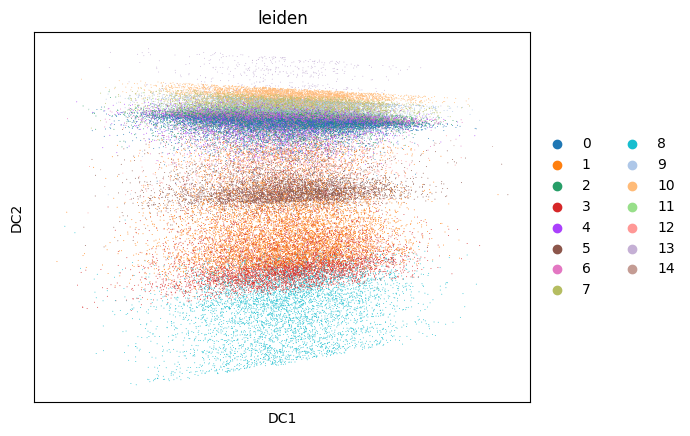

In [53]:
sc.pl.diffmap(ds, color=["leiden"], dimensions=(0, 1))

**Results**:
* As mentioned in docs, DC1 is not interesting for cell type

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


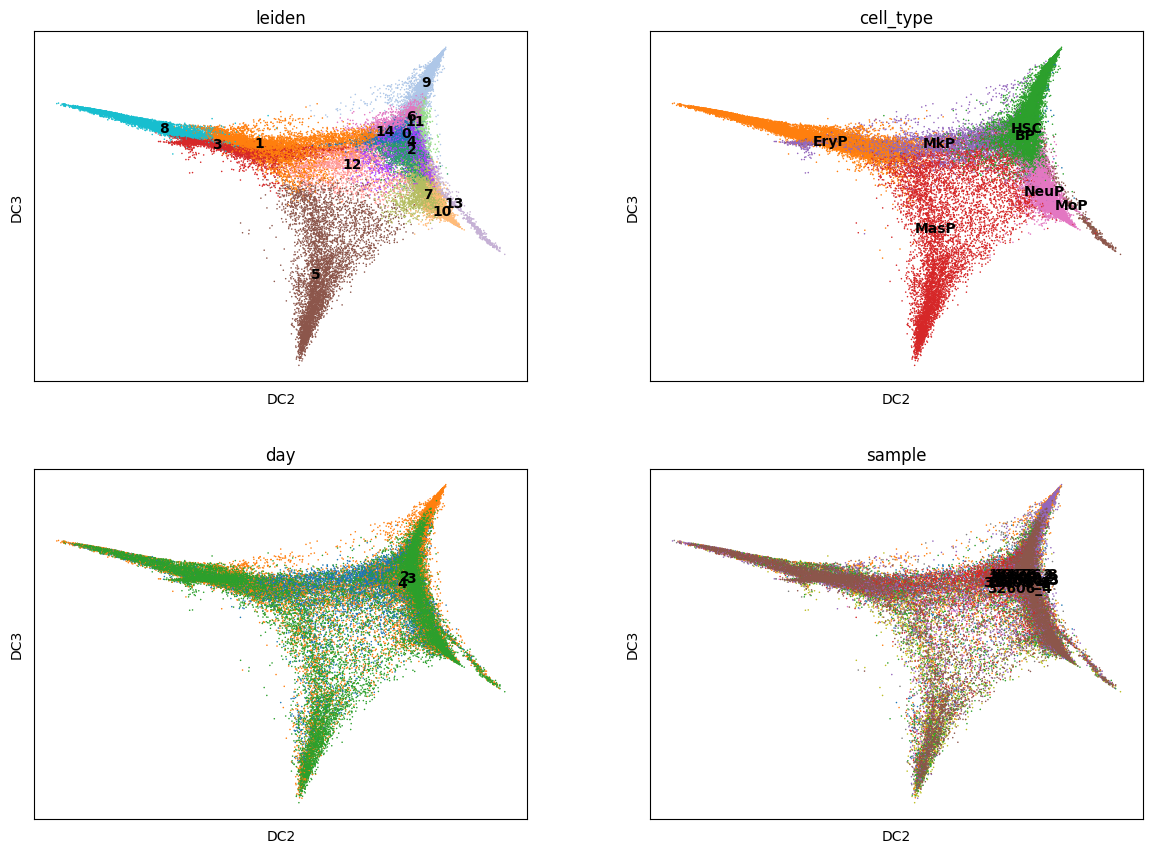

In [54]:
sc.pl.diffmap(
    ds, 
    color=["leiden", "cell_type", "day", "sample"], 
    dimensions=(1, 2), 
    legend_loc="on data", 
    size=5,
    ncols=2
)

**Results**:
* this looks promising!!
* we have a separate cluster (12) for different MkP cells

Let's remove the first DC

In [55]:
ds.obsm["X_diffmap"] = ds.obsm["X_diffmap"][:, 1:]

In [56]:
sc.pp.neighbors(ds, n_neighbors=10, use_rep='X_diffmap', key_added="diff_neighbors")

In [57]:
sc.tl.leiden(ds, resolution=0.2, neighbors_key="diff_neighbors", key_added="diff_leiden")

In [58]:
sc.tl.paga(ds, groups='diff_leiden')

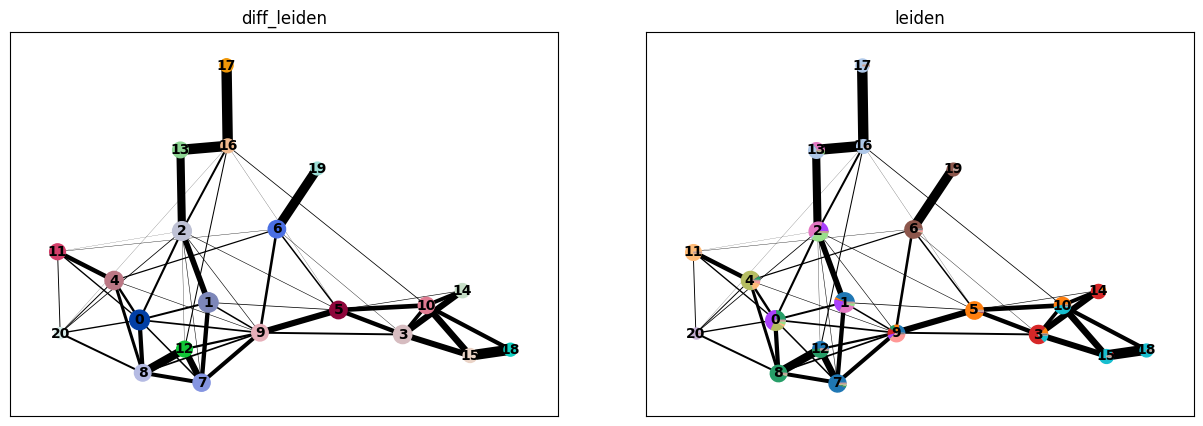

In [59]:
sc.pl.paga(ds, color=["diff_leiden", "leiden"])

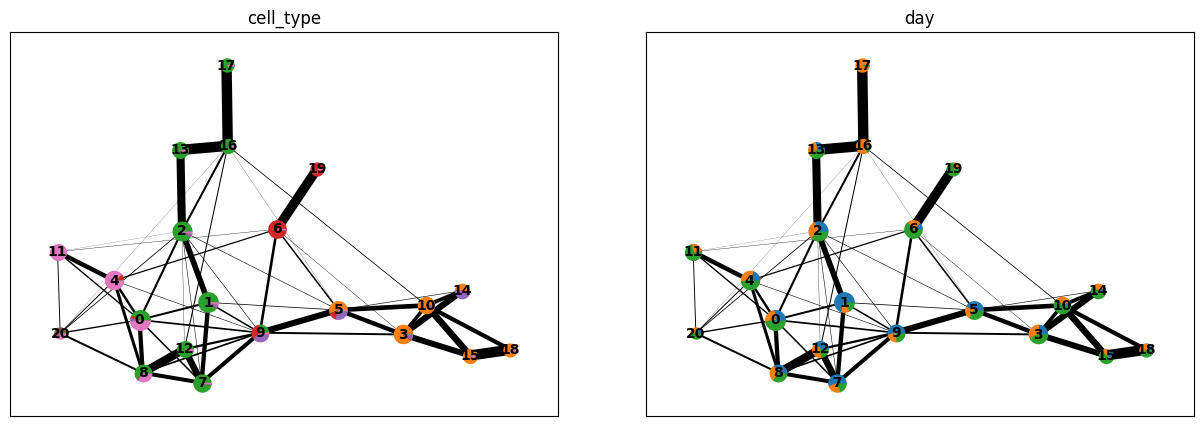

In [60]:
sc.pl.paga(ds, color=["cell_type", "day"])

In [76]:
ds.uns['iroot'] = np.flatnonzero(ds.obs.diff_leiden.eq("1"))[0]

In [77]:
sc.tl.dpt(ds, n_dcs=14)

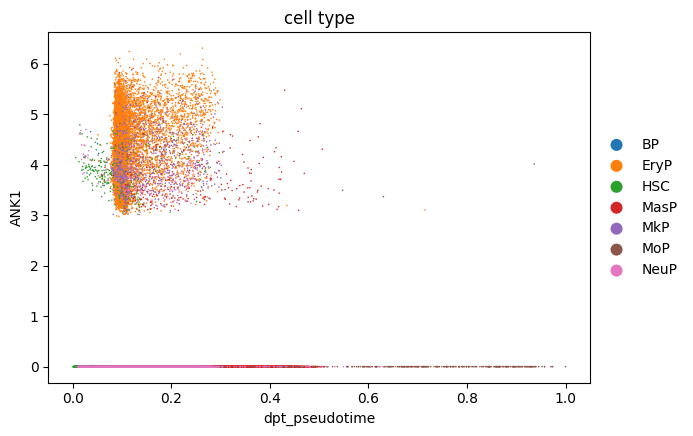

In [79]:
sc.pl.scatter(ds, x="dpt_pseudotime", y="ANK1", color="cell_type", size=5)

In [80]:
sc.tl.umap(ds)

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


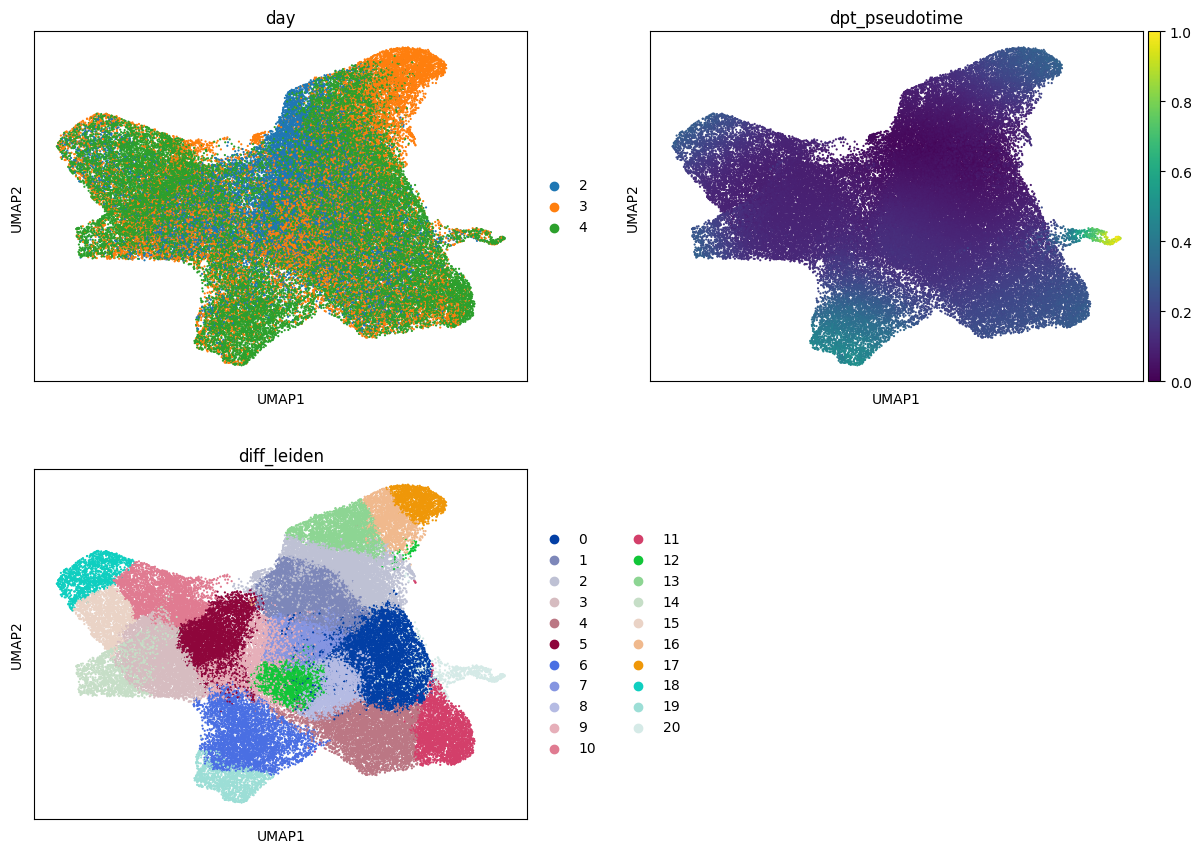

In [81]:
sc.pl.umap(ds, color=["day", "dpt_pseudotime", "diff_leiden"], size=10, ncols=2)

## 6. Composition plots

<AxesSubplot: title={'center': 'Cell_type by day'}>

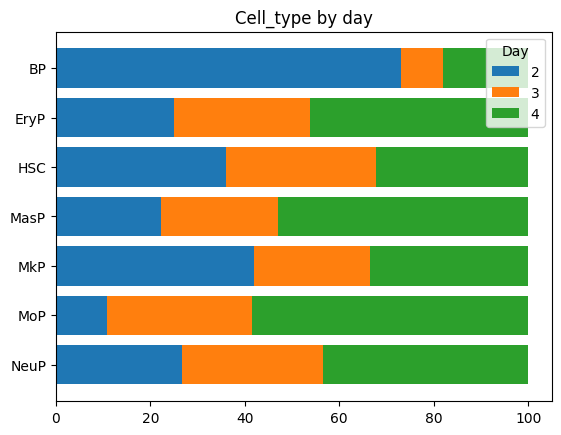

In [66]:
sc_utils.plot_composition(ds, group_by="cell_type", color="day", relative=True)

<AxesSubplot: title={'center': 'Cell_type by day'}>

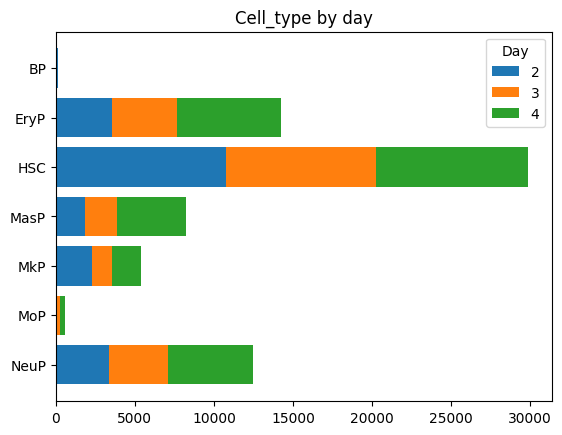

In [67]:
sc_utils.plot_composition(ds, group_by="cell_type", color="day")

<AxesSubplot: title={'center': 'Leiden by cell_type'}>

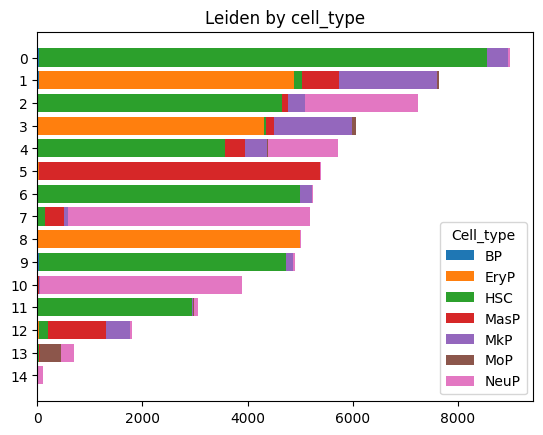

In [68]:
sc_utils.plot_composition(ds, group_by="leiden", color="cell_type")

<AxesSubplot: title={'center': 'Leiden by day'}>

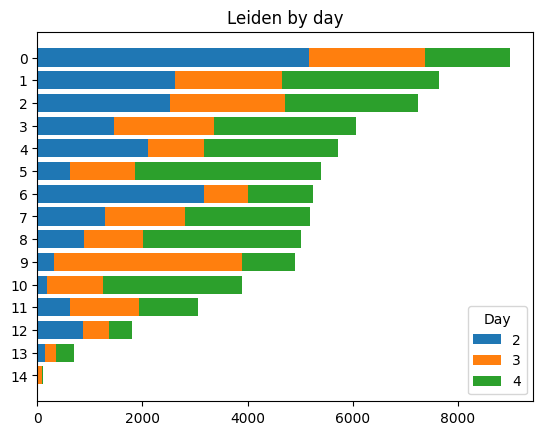

In [69]:
sc_utils.plot_composition(ds, group_by="leiden", color="day")

<AxesSubplot: title={'center': 'Diff_leiden by day'}>

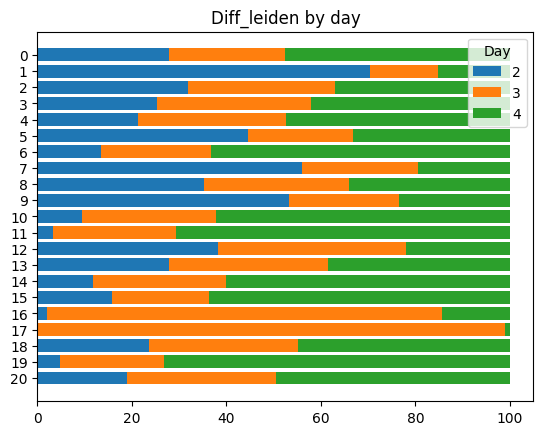

In [70]:
sc_utils.plot_composition(ds, group_by="diff_leiden", color="day", relative=True)

## 7. Dropout analysis per batch/cell_type

This is number of genes per cell per sample: i.e. number of non-zero entries per each cell.

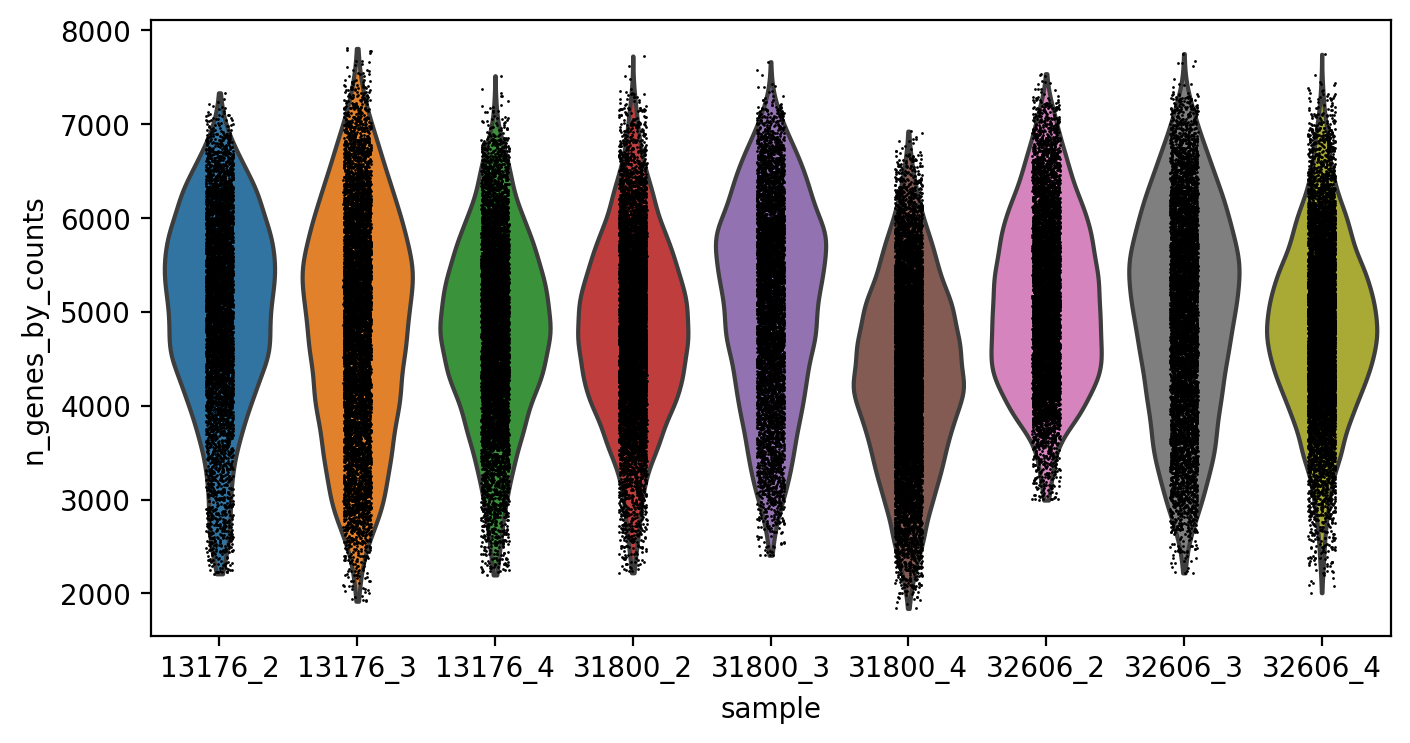

In [84]:
fig, ax = plt.subplots(figsize=(8, 4))
sc.pl.violin(ds, "n_genes_by_counts", groupby="sample", ax=ax)

**Conclusion**:
Sample 31800_4 has fewer genes, everything else looks similar

Let's check if cell type composition is different in that sample?

<AxesSubplot: title={'center': 'Sample by cell_type'}>

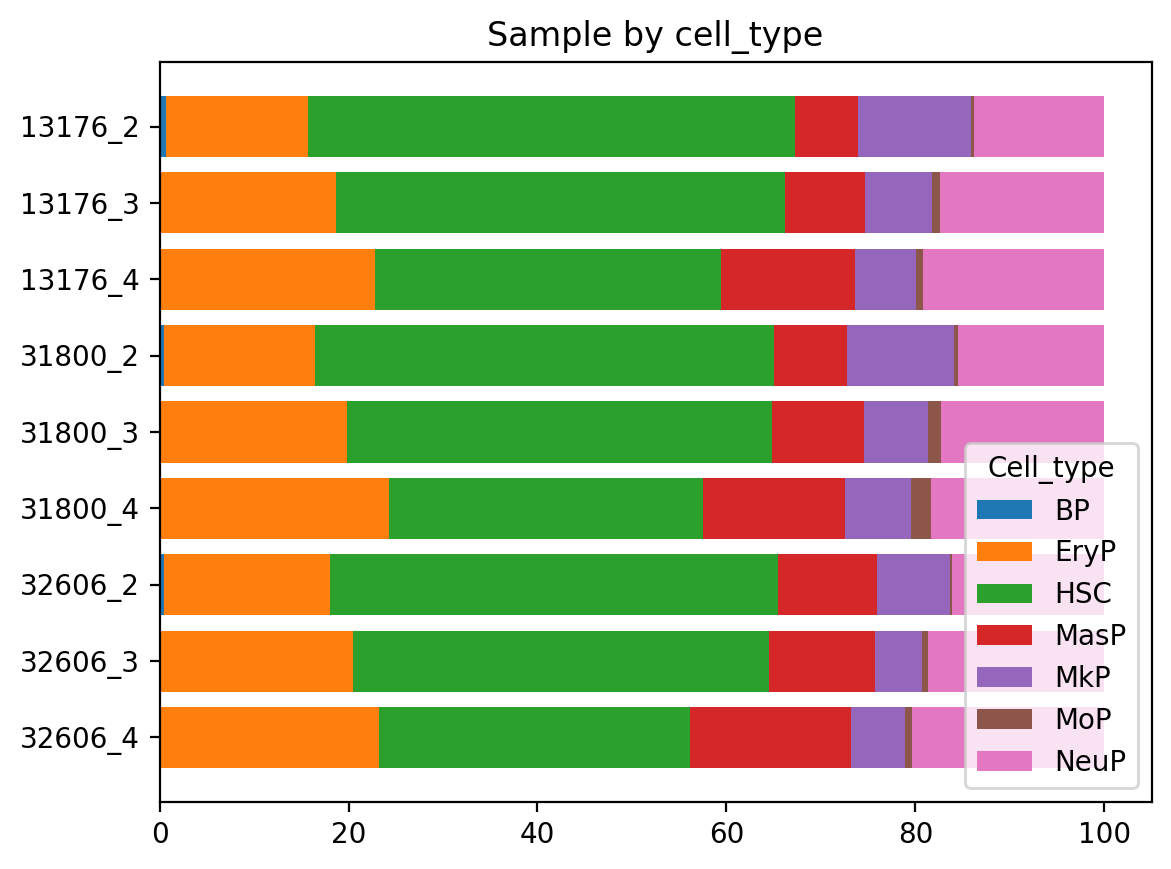

In [86]:
sc_utils.plot_composition(ds, group_by="sample", color="cell_type", relative=True)

No, cell type composition is similar in 31800_4 and the rest

Let's see number of genes per cell type

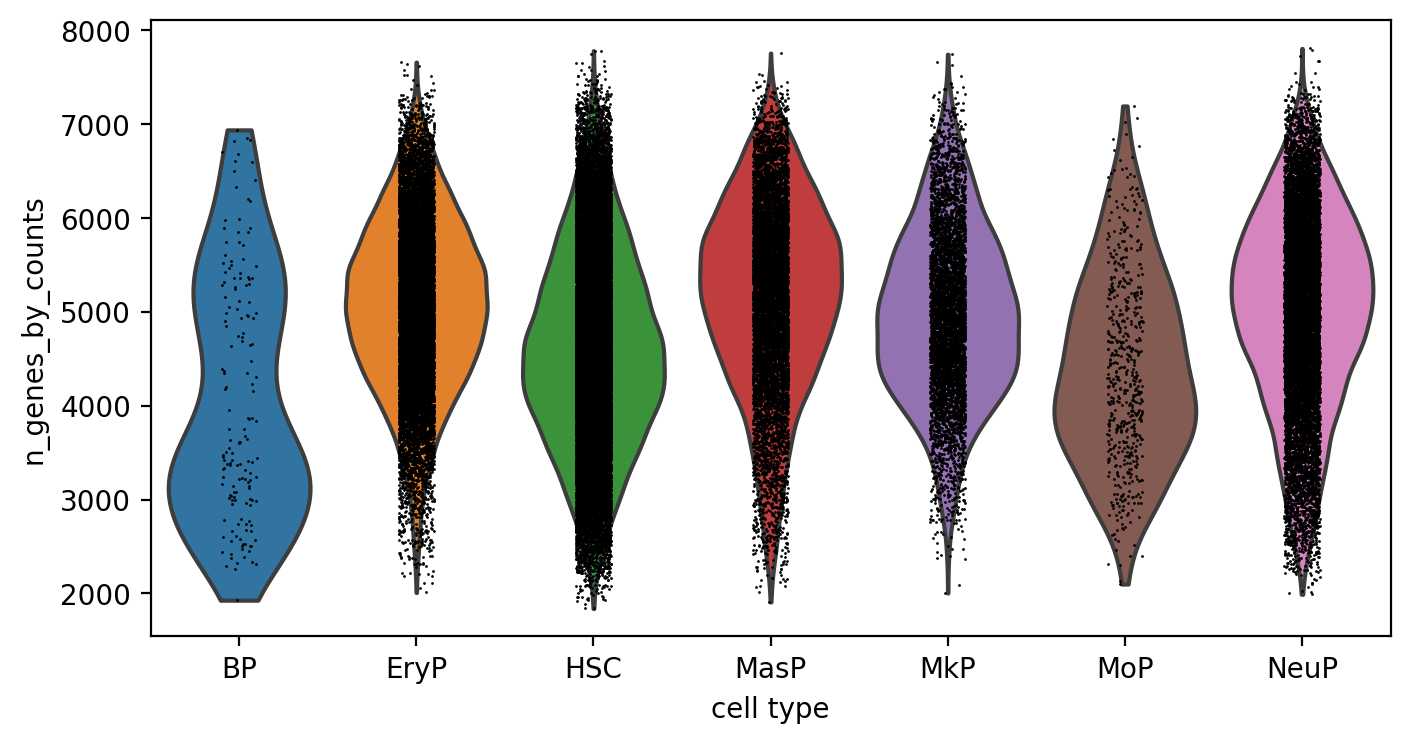

In [87]:
fig, ax = plt.subplots(figsize=(8, 4))
sc.pl.violin(ds, "n_genes_by_counts", groupby="cell_type", ax=ax)

And for each sample

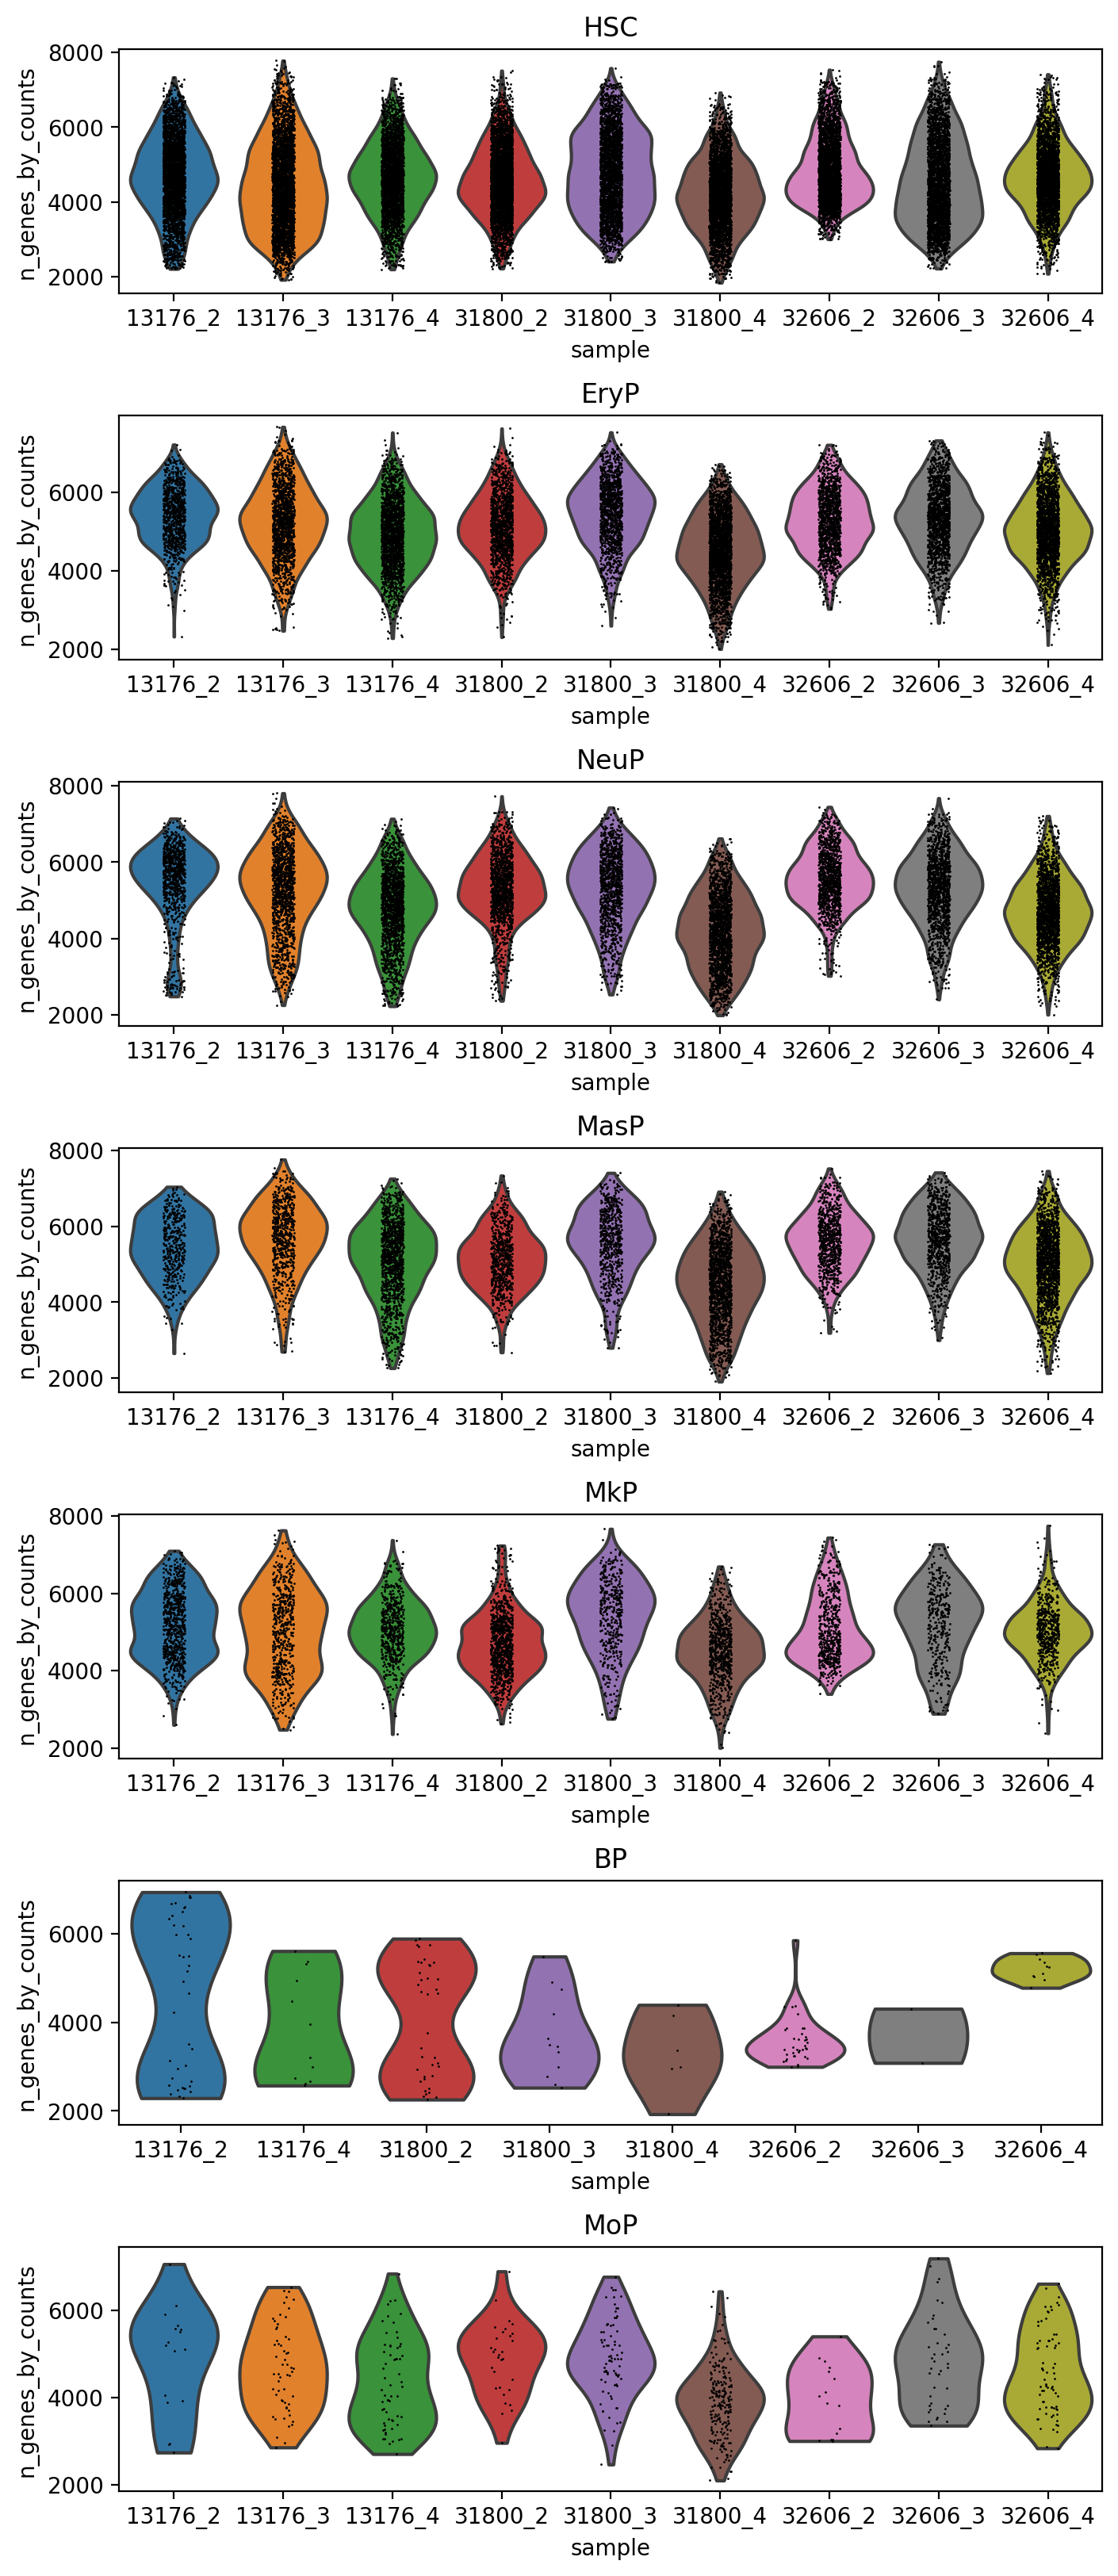

In [103]:
fig, axes = plt.subplots(
    nrows=ds.obs["cell_type"].nunique(), 
    figsize=(8, 20), 
    gridspec_kw={"hspace": 0.5}
)
for i, cell_type in enumerate(ds.obs["cell_type"].unique()):
    sc.pl.violin(ds[ds.obs["cell_type"].eq(cell_type), :], "n_genes_by_counts", groupby="sample", ax=axes[i], show=False)
    axes[i].set_title(cell_type)